# Phân loại Motor Imagery (Left vs Right)


Bài toán: nhận diện tưởng tượng vận động tay trái/phải từ EEG (EEGBCI/PhysioNet).
Lộ trình: đi theo từng chiến lược đánh giá, mỗi chiến lược có hai phương án (PA1/PA2) để so sánh.
- Chiến lược 1 (Cross-Subject): PA1 = CSP + LDA (mốc baseline một dải), PA2 = FBCSP + LDA/SVM (đa băng tần).
- Chiến lược 2 (Subject-Dependent): PA1 = huấn luyện/đánh giá riêng từng subject với CSP + LDA; PA2 = so sánh với baseline cross-subject đã lưu.


## Import và thiết lập
- Nạp MNE/sklearn/seaborn/matplotlib để xử lý EEG, trích đặc trưng và trực quan.
- Cố định thư mục dữ liệu MNE trong repo để tránh tải sang ổ C và giúp tái lập.
- Thiết lập tham số chung (run, cửa sổ epoch, số subject, tỉ lệ train/test, resample) cho toàn bộ notebook.


In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from bci_utils import load_and_preprocess_raw, make_epochs

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


## Cấu hình đường dẫn và tham số
- `MNE_DATA` và `MNE_DATASETS_EEGBCI_PATH` trỏ tới thư mục `mne_data` trong dự án.
- Tạo thư mục lưu kết quả: `outputs_eegmmidb_lr/baseline1_csp_lda`.
- Các tham số chính: danh sách run, cửa sổ epoch, số subject, tỉ lệ test, tần số resample.
- Lưu ý: để baseline correction `baseline=(None, 0)`, epoch cần chứa mốc 0s nên `tmin` đặt âm (ví dụ -0.5s).


In [2]:
PROJECT_DIR = Path().resolve()
OUTPUT_DIR = PROJECT_DIR / "outputs_eegmmidb_lr" / "baseline1_csp_lda"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MNE_DATA_DIR = PROJECT_DIR / "mne_data"
mne.set_config("MNE_DATA", str(MNE_DATA_DIR), set_env=True)
mne.set_config("MNE_DATASETS_EEGBCI_PATH", str(MNE_DATA_DIR), set_env=True)

runs = [4, 8, 12]
tmin, tmax = -0.5, 3.5
n_subjects = 100
test_ratio = 0.2
resample_sfreq = 160.0
random_state = 42

mne.set_log_level("WARNING")


## Hàm trợ giúp

Các bước tiền xử lý được đóng gói trong `bci_utils.py` để tái sử dụng và giữ nhất quán giữa subject. Lý do chọn quy trình này:
1) **Chọn ROI vỏ não vận động**: chỉ giữ các kênh FC/C/CP (Sensorimotor) để tập trung vào nhịp Mu/Beta liên quan vận động, hạn chế nhiễu vùng trán do chớp mắt.
2) **Loại bỏ epoch nhiễu**: dùng ngưỡng biên độ (mặc định 180 µV) để bỏ các trial bị chuyển động cơ/chớp mắt mạnh, tránh làm lệch CSP.
3) **Baseline correction**: `baseline=(None, 0)` chuẩn hóa mức nền trước cue, giúp so sánh ERD/ERS giữa trial công bằng hơn.

Sau đó nạp từng subject, ghép dữ liệu đa-subject, chia train/test theo subject để đánh giá khả năng tổng quát liên-subject.


In [3]:
from typing import Iterable, List, Sequence, Tuple


def load_subject_epochs(
    subject: int,
    runs: Sequence[int],
    tmin: float,
    tmax: float,
    resample_sfreq: float | None,
) -> tuple[np.ndarray, np.ndarray, mne.Epochs]:
    """Nạp một subject và trả về (X, y, epochs) với nhãn 0/1."""
    raw = load_and_preprocess_raw(subject=subject, runs=runs, resample_sfreq=resample_sfreq)
    epochs, event_id = make_epochs(raw, tmin=tmin, tmax=tmax)

    missing = [key for key in ("left_hand", "right_hand") if key not in event_id]
    if missing:
        raise ValueError(f"Subject {subject} thiếu nhãn: {missing}")

    label_map = {event_id["left_hand"]: 0, event_id["right_hand"]: 1}
    y = np.array([label_map[ev] for ev in epochs.events[:, -1]], dtype=int)
    X = epochs.get_data()
    return X, y, epochs


def build_dataset(
    subjects: Iterable[int],
    runs: Sequence[int],
    tmin: float,
    tmax: float,
    resample_sfreq: float | None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, List[int], List[int], mne.Epochs | None]:
    """Ghép nhiều subject thành tập dữ liệu chung."""
    X_all: List[np.ndarray] = []
    y_all: List[np.ndarray] = []
    groups: List[np.ndarray] = []
    loaded: List[int] = []
    skipped: List[int] = []
    example_epochs: mne.Epochs | None = None

    for subject in subjects:
        try:
            X_sub, y_sub, epochs_sub = load_subject_epochs(subject, runs, tmin, tmax, resample_sfreq)
        except Exception as exc:
            print(f"Bỏ qua subject {subject}: {exc}")
            skipped.append(subject)
            continue

        X_all.append(X_sub)
        y_all.append(y_sub)
        groups.append(np.full(len(y_sub), subject, dtype=int))
        loaded.append(subject)
        if example_epochs is None:
            example_epochs = epochs_sub

    if not X_all:
        raise RuntimeError("Không tải được subject nào.")

    X = np.concatenate(X_all, axis=0)
    y = np.concatenate(y_all, axis=0)
    group_labels = np.concatenate(groups, axis=0)
    return X, y, group_labels, loaded, skipped, example_epochs


def split_subjects(
    subjects: Sequence[int],
    test_ratio: float = 0.2,
    seed: int = 42,
) -> tuple[list[int], list[int]]:
    rng = np.random.default_rng(seed)
    shuffled = np.array(subjects)
    rng.shuffle(shuffled)

    n_test = max(1, int(len(shuffled) * test_ratio))
    test_subjects = sorted(shuffled[:n_test].tolist())
    train_subjects = sorted(shuffled[n_test:].tolist())
    if not train_subjects:
        raise ValueError("Train split trống, hãy giảm test_ratio hoặc tăng số subject.")
    return train_subjects, test_subjects


def compute_erd_curves(epochs: mne.Epochs, picks: list[str] | None = None):
    """Trả về thời gian và trung bình tín hiệu left/right (để vẽ ERD/ERS)."""
    if picks:
        epochs = epochs.copy().pick(picks)

    ev_left = epochs["left_hand"].average()
    ev_right = epochs["right_hand"].average()

    left_mean = ev_left.data.mean(axis=0)
    right_mean = ev_right.data.mean(axis=0)
    times = ev_left.times
    return times, left_mean, right_mean


## Chiến lược 1: Cross-Subject Evaluation (đánh giá liên-subject)


## Tải dữ liệu & tạo tập train/test
- Chia subject 80/20 để đo khả năng tổng quát liên-subject.
- Tiền xử lý đồng nhất: ROI motor, baseline correction, reject epoch nhiễu; resample 160 Hz để độ dài epoch đồng nhất.
- Log lại subject được dùng/bỏ qua để kiểm soát chất lượng dữ liệu.


In [4]:
subjects = list(range(1, n_subjects + 1))
train_subjects, test_subjects = split_subjects(subjects, test_ratio=test_ratio, seed=random_state)
print(f"Train subjects ({len(train_subjects)}): {train_subjects[:5]} ...")
print(f"Test subjects  ({len(test_subjects)}): {test_subjects[:5]} ...")

X_train, y_train, groups_train, used_train, skipped_train, example_epochs = build_dataset(
    train_subjects, runs, tmin, tmax, resample_sfreq
)
X_test, y_test, groups_test, used_test, skipped_test, _ = build_dataset(
    test_subjects, runs, tmin, tmax, resample_sfreq
)

print(f"Loaded train subjects: {len(used_train)} / {len(train_subjects)}")
print(f"Skipped train subjects: {skipped_train}")
print(f"Loaded test subjects: {len(used_test)} / {len(test_subjects)}")
print(f"Skipped test subjects: {skipped_test}")

Train subjects (80): [1, 2, 4, 6, 7] ...
Test subjects  (20): [3, 5, 19, 22, 25] ...


d:\KHTK\bci_utils.py:175: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9132\351399941.py:21: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  X = epochs.get_data()
d:\KHTK\bci_utils.py:175: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9132\351399941.py:21: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log 

Loaded train subjects: 80 / 80
Skipped train subjects: []
Loaded test subjects: 20 / 20
Skipped test subjects: []


### Phương án 1: CSP + LDA 


In [5]:
csp_baseline = CSP(n_components=6, reg="ledoit_wolf", log=True, norm_trace=False)
lda_baseline = LinearDiscriminantAnalysis()
csp_lda_clf = Pipeline([("csp", csp_baseline), ("lda", lda_baseline)])

cv = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=random_state)
cv_scores = cross_val_score(csp_lda_clf, X_train, y_train, cv=cv, groups=groups_train, n_jobs=1)
mean_cv = float(np.mean(cv_scores))

csp_lda_clf.fit(X_train, y_train)
y_pred_csp = csp_lda_clf.predict(X_test)
test_acc_csp = accuracy_score(y_test, y_pred_csp)

rows = []
for sid in np.unique(groups_test):
    mask = groups_test == sid
    rows.append({"subject_id": int(sid), "n_trials": int(mask.sum()), "accuracy": float(accuracy_score(y_test[mask], y_pred_csp[mask]))})
csp_per_subject_df = pd.DataFrame(rows).sort_values("subject_id")

print(f"CV mean accuracy (grouped by subject): {mean_cv:.3f}")
print(f"Held-out subject test accuracy: {test_acc_csp:.3f}")
display(csp_per_subject_df.head())

csp_summary = {
    "method": "csp_lda_baseline",
    "n_train_subjects": len(used_train),
    "n_test_subjects": len(used_test),
    "skipped_train_subjects": skipped_train,
    "skipped_test_subjects": skipped_test,
    "cv_mean_accuracy": mean_cv,
    "test_accuracy": float(test_acc_csp),
}

with open(OUTPUT_DIR / "results_csp_lda_baseline.json", "w", encoding="utf-8") as f:
    import json as _json
    _json.dump(csp_summary, f, ensure_ascii=False, indent=2)
csp_per_subject_df.to_csv(OUTPUT_DIR / "results_csp_lda_baseline.csv", index=False)


CV mean accuracy (grouped by subject): 0.585
Held-out subject test accuracy: 0.653


,subject_id,n_trials,accuracy
0,3,42,0.500000
1,5,39,0.487179
2,19,38,0.657895
3,22,33,0.515152
4,25,45,0.666667


### Phương án 2: Filter Bank CSP (FBCSP) + LDA/SVM


In [ ]:
# Naive Filter Bank CSP (FBCSP)
freq_bands = [
    ("Mu", 8.0, 12.0),  
    ("Beta thấp", 12.0, 16.0),  
    ("Beta cao", 16.0, 30.0),  
]

features_train = []
features_test = []
csp_models = []

for band_name, l_freq, h_freq in freq_bands:
    # Lọc dải tần FIR cho từng band
    X_train_band = mne.filter.filter_data(
        X_train,
        sfreq=resample_sfreq,
        l_freq=l_freq,
        h_freq=h_freq,
        method="fir",
        fir_design="firwin",
        verbose=False,
    )
    X_test_band = mne.filter.filter_data(
        X_test,
        sfreq=resample_sfreq,
        l_freq=l_freq,
        h_freq=h_freq,
        method="fir",
        fir_design="firwin",
        verbose=False,
    )

    csp = CSP(n_components=6, reg="ledoit_wolf", log=True, norm_trace=False)
    csp.fit(X_train_band, y_train)
    X_train_feat = csp.transform(X_train_band)
    X_test_feat = csp.transform(X_test_band)

    features_train.append(X_train_feat)
    features_test.append(X_test_feat)
    csp_models.append((band_name, csp))

X_train_fbcsp = np.hstack(features_train)
X_test_fbcsp = np.hstack(features_test)
print(f"Kích thước đặc trưng FBCSP train: {X_train_fbcsp.shape}, test: {X_test_fbcsp.shape}")

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_fbcsp, y_train)
y_pred = lda.predict(X_test_fbcsp)
test_acc = accuracy_score(y_test, y_pred)
print(f"Độ chính xác test (FBCSP + LDA): {test_acc:.3f}")

rows = []
for sid in np.unique(groups_test):
    mask = groups_test == sid
    acc = accuracy_score(y_test[mask], y_pred[mask])
    rows.append({"subject_id": int(sid), "n_trials": int(mask.sum()), "accuracy": float(acc)})
per_subject_df = pd.DataFrame(rows).sort_values("subject_id")
display(per_subject_df.head())

# Lưu kết quả
summary = {
    "method": "naive_fbcsp_lda",
    "freq_bands": freq_bands,
    "n_train_subjects": len(used_train),
    "n_test_subjects": len(used_test),
    "skipped_train_subjects": skipped_train,
    "skipped_test_subjects": skipped_test,
    "test_accuracy": float(test_acc),
}

with open(OUTPUT_DIR / "results_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

per_subject_df.to_csv(OUTPUT_DIR / "results_per_subject.csv", index=False)
print(f"Đã lưu kết quả vào {OUTPUT_DIR}")


Kích thước đặc trưng FBCSP train: (2439, 12), test: (711, 12)
Độ chính xác test (FBCSP + LDA): 0.641


,subject_id,n_trials,accuracy
0,3,42,0.452381
1,5,39,0.512821
2,19,38,0.657895
3,22,33,0.515152
4,25,45,0.688889


Đã lưu kết quả vào D:\KHTK\outputs_eegmmidb_lr\baseline1_csp_lda


### SVM tuyến tính trên đặc trưng FBCSP
Huấn luyện SVM kernel tuyến tính trên vector đặc trưng FBCSP đã chuẩn hóa; so sánh accuracy với LDA baseline.

,Model,Accuracy
0,LDA,0.64135
1,SVM (linear),0.64557


SVM tốt hơn LDA 0.42%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9132\3951079469.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=compare_df, x="Model", y="Accuracy", palette="muted")


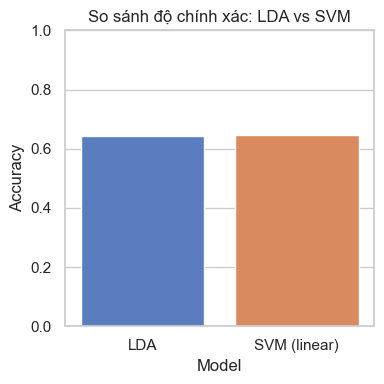

In [7]:
# So sánh SVM (linear) với LDA trên đặc trưng FBCSP
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_clf = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
svm_clf.fit(X_train_fbcsp, y_train)
svm_pred = svm_clf.predict(X_test_fbcsp)
svm_acc = accuracy_score(y_test, svm_pred)

# Bảng so sánh LDA vs SVM
compare_df = pd.DataFrame({
    "Model": ["LDA", "SVM (linear)"],
    "Accuracy": [test_acc, svm_acc],
})
display(compare_df)

diff = svm_acc - test_acc
if diff > 0:
    print(f"SVM tốt hơn LDA {diff*100:.2f}%")
elif diff < 0:
    print(f"SVM kém hơn LDA {-diff*100:.2f}%")
else:
    print("SVM và LDA bằng nhau")

# Biểu đồ so sánh
plt.figure(figsize=(4, 4))
sns.barplot(data=compare_df, x="Model", y="Accuracy", palette="muted")
plt.ylim(0, 1)
plt.title("So sánh độ chính xác: LDA vs SVM")
plt.tight_layout()
plt.show()


### LDA + SVM (giảm chiều trước, phân loại sau)
Chiếu đặc trưng FBCSP qua LDA để nén/khử tương quan, sau đó train SVM tuyến tính; so sánh thêm với hai mô hình trước.

Độ chính xác test (LDA + SVM): 0.643


,Model,Accuracy
0,LDA,0.641350
1,SVM (linear),0.645570
2,LDA + SVM,0.642757


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9132\1183869268.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=compare_df_3, x="Model", y="Accuracy", palette="muted")


LDA + SVM tốt hơn LDA 0.14%


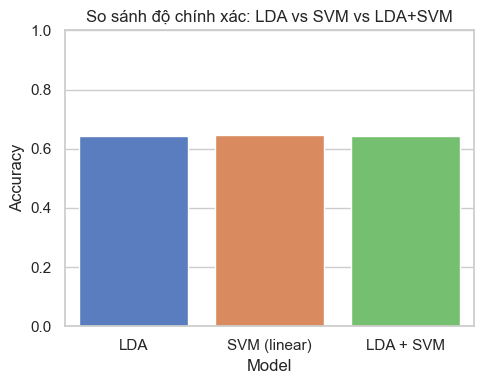

In [8]:
lda_proj = LinearDiscriminantAnalysis(solver="svd")
X_train_lda = lda_proj.fit_transform(X_train_fbcsp, y_train)
X_test_lda = lda_proj.transform(X_test_fbcsp)

lda_svm_clf = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
lda_svm_clf.fit(X_train_lda, y_train)
lda_svm_pred = lda_svm_clf.predict(X_test_lda)
lda_svm_acc = accuracy_score(y_test, lda_svm_pred)
print(f"Độ chính xác test (LDA + SVM): {lda_svm_acc:.3f}")

compare_df_3 = pd.DataFrame({
    "Model": ["LDA", "SVM (linear)", "LDA + SVM"],
    "Accuracy": [test_acc, svm_acc, lda_svm_acc],
})
display(compare_df_3)

diff_lda_svm_vs_lda = lda_svm_acc - test_acc
if diff_lda_svm_vs_lda > 0:
    print(f"LDA + SVM tốt hơn LDA {diff_lda_svm_vs_lda*100:.2f}%")
elif diff_lda_svm_vs_lda < 0:
    print(f"LDA + SVM kém hơn LDA {-diff_lda_svm_vs_lda*100:.2f}%")
else:
    print("LDA + SVM bằng LDA")

plt.figure(figsize=(5, 4))
sns.barplot(data=compare_df_3, x="Model", y="Accuracy", palette="muted")
plt.ylim(0, 1)
plt.title("So sánh độ chính xác: LDA vs SVM vs LDA+SVM")
plt.tight_layout()
plt.show()


## Trực quan ERD/ERS (Evoked trung bình)
- Tính trung bình tín hiệu cho cue tay trái/phải.
- Vẽ đường thời gian (line chart) để quan sát khác biệt ERD/ERS.
- Ưu tiên kênh C3/C4 (nếu có); nếu không thì dùng toàn bộ kênh.

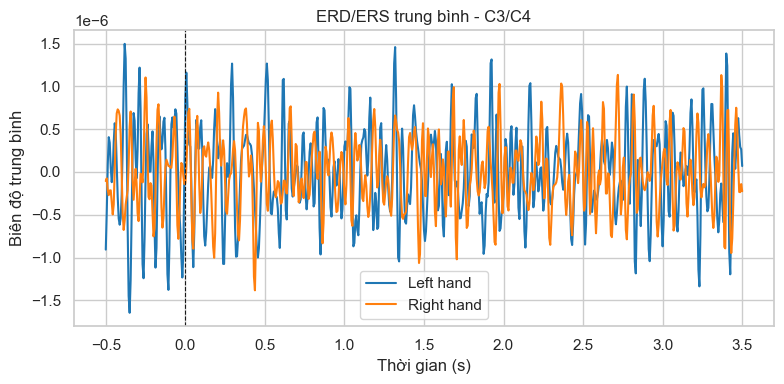

In [9]:
if example_epochs is None:
    raise RuntimeError("Không có epochs mẫu để vẽ ERD/ERS.")

motor_chs = [ch for ch in ("C3", "C4") if ch in example_epochs.ch_names]
picks = motor_chs if motor_chs else None

times, left_mean, right_mean = compute_erd_curves(example_epochs, picks=picks)

plt.figure(figsize=(8, 4))
plt.plot(times, left_mean, label="Left hand", color="tab:blue")
plt.plot(times, right_mean, label="Right hand", color="tab:orange")
plt.axvline(0, color="k", linestyle="--", linewidth=0.8)
plt.xlabel("Thời gian (s)")
plt.ylabel("Biên độ trung bình")
title_ch = "C3/C4" if picks else "Tất cả kênh"
plt.title(f"ERD/ERS trung bình - {title_ch}")
plt.legend()
plt.tight_layout()
plt.show()

## Mẫu không gian CSP (Topomap)
- Hiển thị các pattern của CSP để xem vùng não đóng góp mạnh vào phân biệt hai lớp.

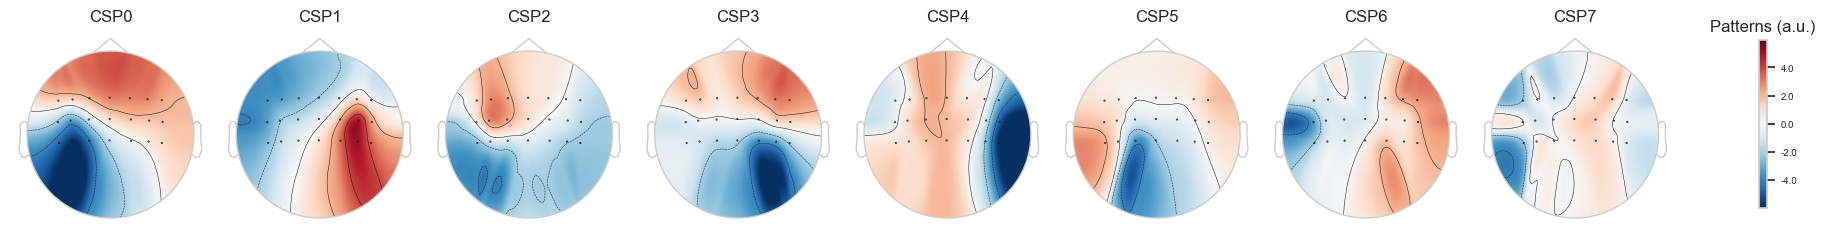

<Figure size 800x400 with 0 Axes>

In [10]:
if "csp_models" not in globals() or not csp_models:
    raise RuntimeError("Hãy chạy cell huấn luyện FBCSP trước khi vẽ CSP patterns.")

band_to_plot = "Mu"  # hoặc "Beta thấp" / "Beta cao"
name_to_plot, csp_to_plot = next(((n, c) for n, c in csp_models if n == band_to_plot), csp_models[0])

components_to_plot = list(range(min(8, csp_to_plot.filters_.shape[0])))
csp_to_plot.plot_patterns(example_epochs.info, ch_type="eeg", units="Patterns (a.u.)", size=1.5, components=components_to_plot)
plt.suptitle(f"CSP patterns ({name_to_plot})")
plt.show()


## Biểu đồ accuracy theo từng subject test
- Quan sát subject nào có hiệu năng cao/thấp hơn.

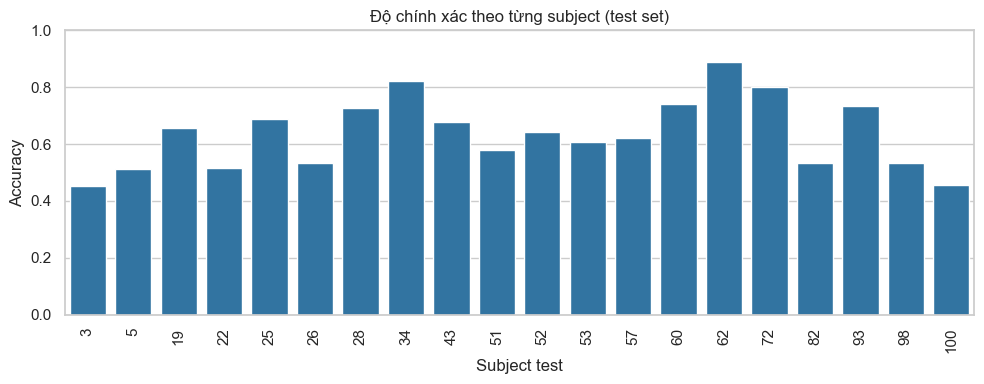

In [11]:
plt.figure(figsize=(10, 4))
sns.barplot(data=per_subject_df, x="subject_id", y="accuracy", color="tab:blue")
plt.xticks(rotation=90)
plt.ylim(0, 1.0)
plt.xlabel("Subject test")
plt.ylabel("Accuracy")
plt.title("Độ chính xác theo từng subject (test set)")
plt.tight_layout()
plt.show()

## Ma trận nhầm lẫn (Confusion Matrix)
- Đánh giá chi tiết phân bố dự đoán Left/Right trên tập test.

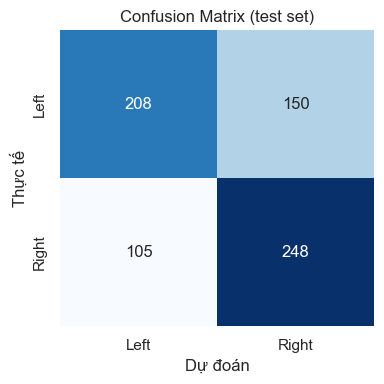

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Left", "Right"], yticklabels=["Left", "Right"])
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix (test set)")
plt.tight_layout()
plt.show()

## Chiến lược 2: Subject-Dependent Evaluation (cá nhân hóa)

- Chỉ giữ phương án 2: Filter Bank CSP (FBCSP) với phân loại LDA/SVM trên từng subject.


### Phương án 2: Filter Bank CSP (FBCSP) + LDA/SVM (cải tiến)


#### Các bước PA2 (FBCSP + LDA/SVM)
1. Tiền xử lý/epoch từng subject giống CL1.
2. Lọc 3 dải Mu/Beta, huấn luyện CSP từng dải, ghép đặc trưng FBCSP.
3. Đánh giá LDA, SVM, LDA+SVM; lấy biến thể tốt nhất theo accuracy.
4. Lưu accuracy từng subject cho bước so sánh.


In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import mne
from mne.decoding import CSP
from bci_utils import load_and_preprocess_raw, make_epochs
freq_bands = [
    ("Mu", 8.0, 12.0),
    ("Beta_low", 12.0, 16.0),
    ("Beta_high", 16.0, 30.0),
]
resample_subdep = resample_sfreq
tmin_subdep = tmin
tmax_subdep = tmax
rows = []
skipped_subjects = []
out_path = Path("outputs_eegmmidb_lr") / "baseline1_csp_lda" / "results_fbcsp_subject_dependent.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
for subject in tqdm(range(1, n_subjects + 1), desc="Subject-dependent FBCSP", disable=True):
    try:
        raw = load_and_preprocess_raw(subject=subject, runs=runs, resample_sfreq=resample_subdep)
        epochs, event_id = make_epochs(raw, tmin=tmin_subdep, tmax=tmax_subdep)
        missing = [key for key in ("left_hand", "right_hand") if key not in event_id]
        if missing:
            raise ValueError(f"Thieu nhan {missing}")
        label_map = {event_id["left_hand"]: 0, event_id["right_hand"]: 1}
        y = np.array([label_map[val] for val in epochs.events[:, -1]], dtype=int)
        X = epochs.get_data()
        if len(y) < 10 or len(np.unique(y)) < 2:
            skipped_subjects.append(subject)
            continue
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        feats_train = []
        feats_test = []
        for _, l_freq, h_freq in freq_bands:
            X_train_band = mne.filter.filter_data(
                X_train, sfreq=resample_subdep, l_freq=l_freq, h_freq=h_freq, method="fir", fir_design="firwin", verbose=False
            )
            X_test_band = mne.filter.filter_data(
                X_test, sfreq=resample_subdep, l_freq=l_freq, h_freq=h_freq, method="fir", fir_design="firwin", verbose=False
            )
            csp = CSP(n_components=4, reg="ledoit_wolf", log=True, norm_trace=False)
            csp.fit(X_train_band, y_train)
            feats_train.append(csp.transform(X_train_band))
            feats_test.append(csp.transform(X_test_band))
        X_train_fb = np.hstack(feats_train)
        X_test_fb = np.hstack(feats_test)
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_fb, y_train)
        acc_lda = accuracy_score(y_test, lda.predict(X_test_fb))
        svm = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
        svm.fit(X_train_fb, y_train)
        acc_svm = accuracy_score(y_test, svm.predict(X_test_fb))
        lda_proj = LinearDiscriminantAnalysis(solver="svd")
        X_train_lda = lda_proj.fit_transform(X_train_fb, y_train)
        X_test_lda = lda_proj.transform(X_test_fb)
        lda_svm = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
        lda_svm.fit(X_train_lda, y_train)
        acc_lda_svm = accuracy_score(y_test, lda_svm.predict(X_test_lda))
        rows.append({
            "subject_id": subject,
            "n_trials": int(len(y)),
            "accuracy_lda": float(acc_lda),
            "accuracy_svm": float(acc_svm),
            "accuracy_lda_svm": float(acc_lda_svm),
        })
    except Exception as exc:
        skipped_subjects.append(subject)
        print(f"Bo qua subject {subject}: {exc}")
cols = ["subject_id", "n_trials", "accuracy_lda", "accuracy_svm", "accuracy_lda_svm"]
fbcsp_df = pd.DataFrame(rows, columns=cols)
fbcsp_df.to_csv(out_path, index=False)
print(f"Luu {len(fbcsp_df)} subject tai {out_path}")
if skipped_subjects:
    print(f"Subject bi bo qua: {sorted(set(skipped_subjects))}")
if fbcsp_df.empty:
    print("Khong co ket qua subject-dependent nao duoc luu; kiem tra log bo qua o tren.")


d:\KHTK\bci_utils.py:175: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9132\3754818492.py:35: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  X = epochs.get_data()
d:\KHTK\bci_utils.py:175: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9132\3754818492.py:35: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_lo

Luu 87 subject tai outputs_eegmmidb_lr\baseline1_csp_lda\results_fbcsp_subject_dependent.csv
Subject bi bo qua: [9, 13, 17, 24, 32, 44, 48, 49, 56, 75, 79, 95, 99]


#### So sánh tổng hợp
- So sánh 3 lựa chọn: CL1 PA1 (CSP+LDA cross-subject), CL1 PA2 (FBCSP cross-subject), CL2 PA2 (FBCSP per-subject).
- Với PA2, chọn biến thể phân loại có accuracy trung bình cao nhất (ví dụ FBCSP+SVM nếu cao nhất).


Độ chính xác trung bình - CL1 PA1 (CSP+LDA cross-subject): 0.642
Độ chính xác trung bình - CL1 PA2 (FBCSP cross-subject): 0.636
Độ chính xác trung bình - CL2 PA2 (FBCSP per-subject, biến thể tốt nhất mỗi subject): 0.655
Biến thể tốt nhất PA2 (subject-dependent) theo mean: svm -> 0.582


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9132\2626370336.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="method", y="accuracy", palette=["#4C72B0", "#55A868", "#C44E52"])


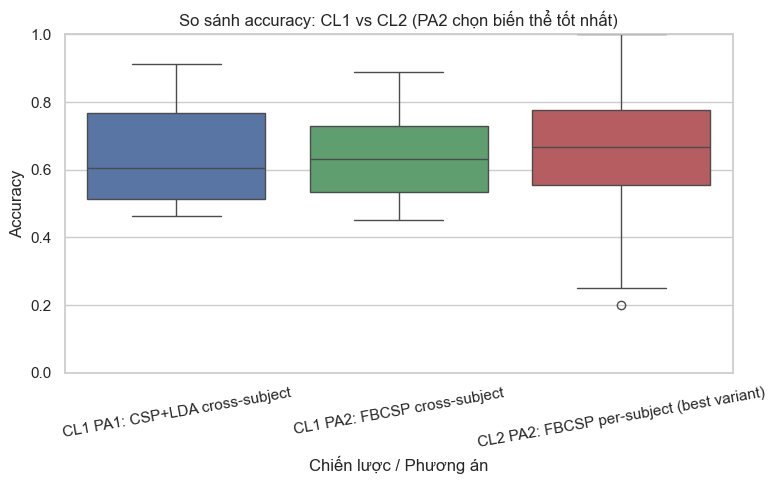

In [14]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

OUTPUT_DIR = Path("outputs_eegmmidb_lr") / "baseline1_csp_lda"
csp_cs_path = OUTPUT_DIR / "results_csp_lda_baseline.csv"
fbcsp_cs_path = OUTPUT_DIR / "results_per_subject.csv"
fbcsp_sd_path = OUTPUT_DIR / "results_fbcsp_subject_dependent.csv"

if not fbcsp_sd_path.exists() or fbcsp_sd_path.stat().st_size == 0:
    raise FileNotFoundError("results_fbcsp_subject_dependent.csv is empty. Run the subject-dependent FBCSP cell first.")

csp_cs_df = pd.read_csv(csp_cs_path)
fbcsp_cs_df = pd.read_csv(fbcsp_cs_path)
try:
    fbcsp_sd_df = pd.read_csv(fbcsp_sd_path)
except pd.errors.EmptyDataError as exc:
    raise ValueError("results_fbcsp_subject_dependent.csv has no columns or rows. Run the subject-dependent FBCSP cell first.") from exc
if fbcsp_sd_df.empty:
    raise ValueError("results_fbcsp_subject_dependent.csv has no rows. Run the subject-dependent FBCSP cell first.")

mean_csp_cs = csp_cs_df["accuracy"].mean()
mean_fbcsp_cs = fbcsp_cs_df["accuracy"].mean()
fbcsp_sd_best = fbcsp_sd_df[["accuracy_lda", "accuracy_svm", "accuracy_lda_svm"]].max(axis=1)
mean_fbcsp_sd_best = fbcsp_sd_best.mean()
mean_fbcsp_sd = {
    "lda": fbcsp_sd_df["accuracy_lda"].mean(),
    "svm": fbcsp_sd_df["accuracy_svm"].mean(),
    "lda_svm": fbcsp_sd_df["accuracy_lda_svm"].mean(),
}
best_variant_sd = max(mean_fbcsp_sd, key=mean_fbcsp_sd.get)

print(f"Độ chính xác trung bình - CL1 PA1 (CSP+LDA cross-subject): {mean_csp_cs:.3f}")
print(f"Độ chính xác trung bình - CL1 PA2 (FBCSP cross-subject): {mean_fbcsp_cs:.3f}")
print(f"Độ chính xác trung bình - CL2 PA2 (FBCSP per-subject, biến thể tốt nhất mỗi subject): {mean_fbcsp_sd_best:.3f}")
print(f"Biến thể tốt nhất PA2 (subject-dependent) theo mean: {best_variant_sd} -> {mean_fbcsp_sd[best_variant_sd]:.3f}")

plot_df = pd.concat(
    [
        csp_cs_df[["accuracy"]].assign(method="CL1 PA1: CSP+LDA cross-subject"),
        fbcsp_cs_df[["accuracy"]].assign(method="CL1 PA2: FBCSP cross-subject"),
        fbcsp_sd_best.to_frame(name="accuracy").assign(method="CL2 PA2: FBCSP per-subject (best variant)"),
    ],
    ignore_index=True,
)

plt.figure(figsize=(8, 5))
sns.boxplot(data=plot_df, x="method", y="accuracy", palette=["#4C72B0", "#55A868", "#C44E52"])
plt.title("So sánh accuracy: CL1 vs CL2 (PA2 chọn biến thể tốt nhất)")
plt.xlabel("Chiến lược / Phương án")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

summary = {
    "CL1_PA1_CSP_LDA_cross_subject": {"mean_accuracy": float(mean_csp_cs)},
    "CL1_PA2_FBCSP_LDA_cross_subject": {"mean_accuracy": float(mean_fbcsp_cs)},
    "CL2_PA2_FBCSP_subject": {
        "mean_accuracy_best_per_subject": float(mean_fbcsp_sd_best),
        "mean_accuracy_lda": float(mean_fbcsp_sd["lda"]),
        "mean_accuracy_svm": float(mean_fbcsp_sd["svm"]),
        "mean_accuracy_lda_svm": float(mean_fbcsp_sd["lda_svm"]),
        "best_variant_by_mean": best_variant_sd,
    },
}
with open(OUTPUT_DIR / "results_accuracy_summary.json", "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
